In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import sklearn

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split


# Loading dataset

In [2]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [3]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.head(100)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
95,Daniel Day-Lewis is the most versatile actor a...,positive
96,My guess would be this was originally going to...,negative
97,"Well, I like to watch bad horror B-Movies, cau...",negative
98,"This IS the worst movie I have ever seen, as w...",negative


In [5]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

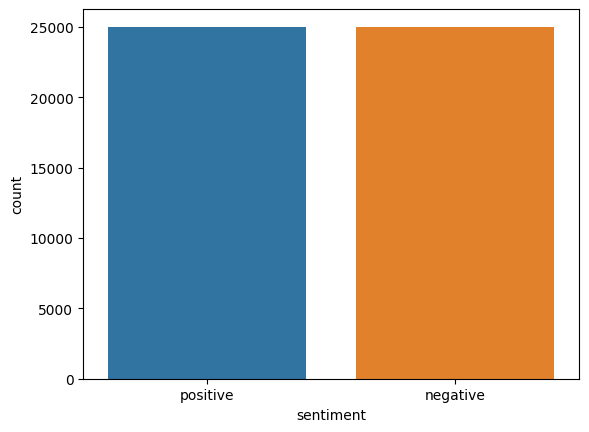

In [6]:
# Let's observe distribution of positive / negative sentiments in dataset
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

# Data Preprocessing

In [7]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [11]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
# Sample cleaned up movie review 

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [13]:
movie_reviews['sentiment'] = movie_reviews.sentiment.map({'negative':0, 'positive':1})

In [14]:
movie_reviews.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


# Preparing Embedding layer

In [15]:
# Creating Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=30000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="<OOV>")

In [16]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=150, padding='post', truncating='post')
    
    return sequences

In [17]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
def movie_review_encoder(df):
    df = df.copy()

    # Split df into X and Y
    X = df['review']
    y = df['sentiment']

    # Train-Test-Validation Split - 80:10:10
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=True, random_state=42)
    
    # Fitting the Tokenizer
    tokenizer.fit_on_texts(X_train)
    tokenizer.fit_on_texts(X_val)
    
    # Converting Texts to Sequences
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])
    X_val = get_sequences(X_val, tokenizer, train=True)
    

    return X_train, X_test, X_val, y_train, y_test, y_val

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [18]:
X_train, X_test, X_val, y_train, y_test, y_val = movie_review_encoder(movie_reviews)

In [19]:
X_train

array([[ 198,   49,   11, ...,    1,    9,    2],
       [  11,  117,   22, ...,   82, 3831,   21],
       [   4, 1362,  114, ...,    0,    0,    0],
       ...,
       [ 794,   12,   28, ...,    0,    0,    0],
       [  12,  359,   14, ...,    0,    0,    0],
       [  12,    7,    4, ...,    0,    0,    0]], dtype=int32)

In [20]:
X_test

array([[  371,    46, 14784, ...,  2187,  1671,  2433],
       [    4, 19495,     7, ...,     2,  1126,    12],
       [   44,    23,    38, ...,     0,     0,     0],
       ...,
       [   11,   190,   381, ...,     0,     0,     0],
       [    2,   238,  2383, ...,     6,   140,   142],
       [   11,   237,  1682, ...,    63,   333,   777]], dtype=int32)

In [21]:
X_val

array([[    2, 23798,   896, ...,     0,     0,     0],
       [  250,    37,   684, ...,     0,     0,     0],
       [  146,  1277,    11, ...,   374,     5,  3300],
       ...,
       [  136,    85,    16, ...,     0,     0,     0],
       [   45,    28,     5, ...,    69,   122,     2],
       [   11,    86,   213, ...,     0,     0,     0]], dtype=int32)

In [22]:
y_val

25056    0
30334    0
17962    0
39588    0
34107    0
        ..
35412    0
13542    1
10989    0
27438    0
1138     1
Name: sentiment, Length: 5000, dtype: int64

In [23]:
X_train.shape

(40000, 150)

In [24]:
y_train.value_counts()

0    20039
1    19961
Name: sentiment, dtype: int64

# Model Training with:

# Simple Neural Network

In [26]:
# Simple Neural Network architecture

snn_model = Sequential()
snn_model.add(Embedding(input_dim = 30000, 
                          output_dim = 64,
                          input_length = X_train.shape[1]
                          ))


snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [27]:
# Model compiling
snn_opt = keras.optimizers.Adam(learning_rate=0.0001)
snn_model.compile(optimizer = snn_opt, loss='binary_crossentropy', metrics=['accuracy'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           1920000   
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 1)                 9601      
                                                                 
Total params: 1,929,601
Trainable params: 1,929,601
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
313/313 [==============================] - 11s 33ms/step - loss: 0.6911 - accuracy: 0.5302 - val_loss: 0.6878 - val_accuracy: 0.5730
Epoch 2/15
313/313 [==============================] - 15s 47ms/step - loss: 0.6724 - accuracy: 0.6874 - val_loss: 0.6571 - val_accuracy: 0.7030
Epoch 3/15
313/313 [==============================] - 11s 36ms/step - loss: 0.6072 - accuracy: 0.7627 - val_loss: 0.5677 - val_accuracy: 0.7710
Epoch 4/15
313/313 [==============================] - 10s 33ms/step - loss: 0.5022 - accuracy: 0.8113 - val_loss: 0.4718 - val_accuracy: 0.8164
Epoch 5/15
313/313 [==============================] - 10s 33ms/step - loss: 0.4147 - accuracy: 0.8472 - val_loss: 0.4097 - val_accuracy: 0.8410
Epoch 6/15
313/313 [==============================] - 10s 33ms/step - loss: 0.3563 - accuracy: 0.8691 - val_loss: 0.3722 - val_accuracy: 0.8500
Epoch 7/15
313/313 [==============================] - 9s 30ms/step - loss: 0.3159 - accuracy: 0.8857 - val_loss: 0.3472 - val_accuracy: 

In [29]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 0s 3ms/step - loss: 0.3004 - accuracy: 0.8720


In [30]:
# Model Performance

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.3003629744052887
Test Accuracy: 0.871999979019165


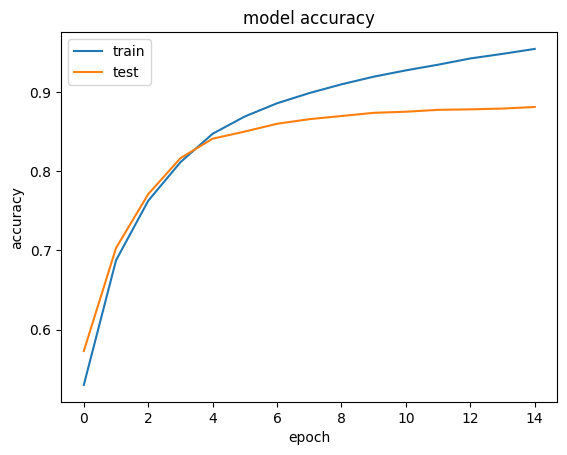

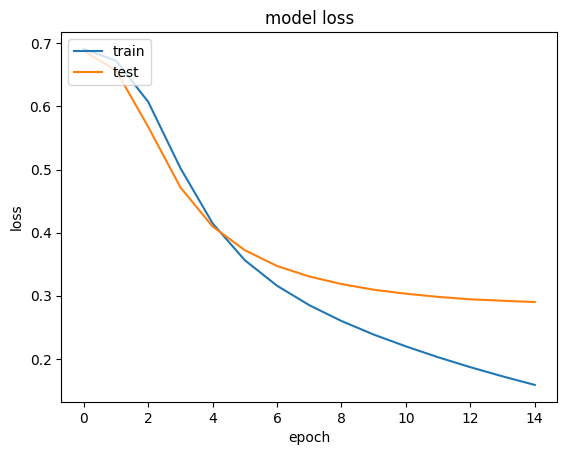

In [33]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['accuracy'])
plt.plot(snn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [35]:
from keras.layers import Conv1D

In [36]:
# Convolutional Neural Network architecture

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim = 30000, 
                          output_dim = 64,
                          input_length = X_train.shape[1]
                          ))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [37]:
# Model compiling
cnn_opt = keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer = cnn_opt, loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 64)           1920000   
                                                                 
 conv1d (Conv1D)             (None, 146, 128)          41088     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,961,217
Trainable params: 1,961,217
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
313/313 [==============================] - 51s 159ms/step - loss: 0.6900 - accuracy: 0.5949 - val_loss: 0.6825 - val_accuracy: 0.7088
Epoch 2/15
313/313 [==============================] - 49s 156ms/step - loss: 0.6508 - accuracy: 0.7448 - val_loss: 0.6028 - val_accuracy: 0.7550
Epoch 3/15
313/313 [==============================] - 45s 144ms/step - loss: 0.5458 - accuracy: 0.7574 - val_loss: 0.4970 - val_accuracy: 0.7708
Epoch 4/15
313/313 [==============================] - 46s 148ms/step - loss: 0.4601 - accuracy: 0.7867 - val_loss: 0.4370 - val_accuracy: 0.8016
Epoch 5/15
313/313 [==============================] - 49s 155ms/step - loss: 0.4011 - accuracy: 0.8218 - val_loss: 0.3985 - val_accuracy: 0.8222
Epoch 6/15
313/313 [==============================] - 50s 160ms/step - loss: 0.3540 - accuracy: 0.8501 - val_loss: 0.3727 - val_accuracy: 0.8410
Epoch 7/15
313/313 [==============================] - 48s 153ms/step - loss: 0.3139 - accuracy: 0.8717 - val_loss: 0.3548 - val_ac

In [39]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 1s 9ms/step - loss: 0.3615 - accuracy: 0.8512


In [40]:
# Model Performance

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.3614581823348999
Test Accuracy: 0.8511999845504761


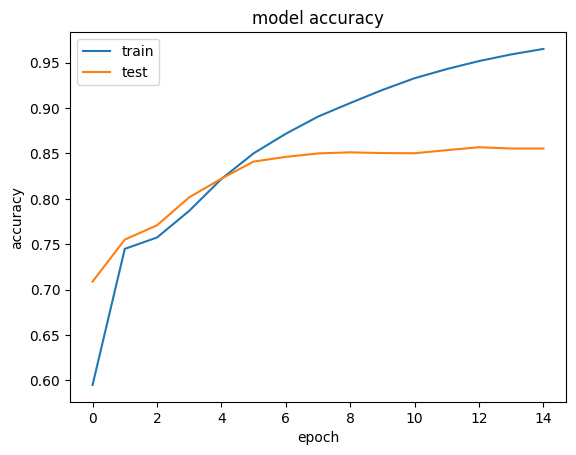

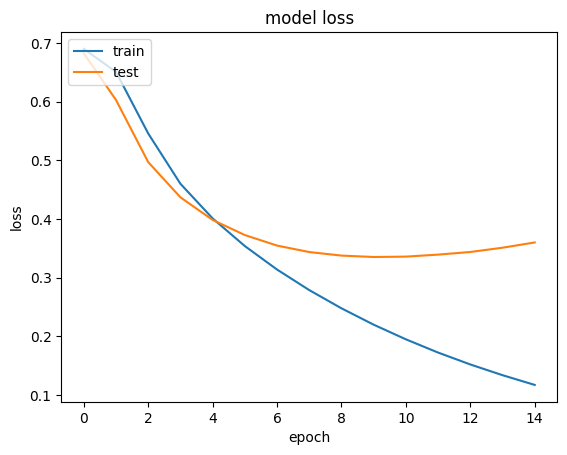

In [43]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Recurrent Neural Network (LSTM)

In [72]:
from keras.layers import Bidirectional
from keras.layers import LSTM

In [75]:
# Recurrent Neural Network architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = 30000, 
                          output_dim = 64,
                          input_length = X_train.shape[1]
                          ))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dense(1, activation = 'sigmoid'))

In [77]:
# Model compiling
lstm_opt = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer = lstm_opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 64)           1920000   
                                                                 
 lstm_19 (LSTM)              (None, 128)               98816     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,018,945
Trainable params: 2,018,945
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
313/313 [==============================] - 166s 521ms/step - loss: 0.6373 - accuracy: 0.5880 - val_loss: 0.4522 - val_accuracy: 0.7958
Epoch 2/15
313/313 [==============================] - 167s 533ms/step - loss: 0.3588 - accuracy: 0.8470 - val_loss: 0.3448 - val_accuracy: 0.8528
Epoch 3/15
313/313 [==============================] - 167s 532ms/step - loss: 0.2600 - accuracy: 0.8977 - val_loss: 0.3292 - val_accuracy: 0.8618
Epoch 4/15
313/313 [==============================] - 167s 534ms/step - loss: 0.2079 - accuracy: 0.9213 - val_loss: 0.3348 - val_accuracy: 0.8614
Epoch 5/15
313/313 [==============================] - 168s 538ms/step - loss: 0.1641 - accuracy: 0.9416 - val_loss: 0.3467 - val_accuracy: 0.8630
Epoch 6/15
313/313 [==============================] - 166s 530ms/step - loss: 0.1339 - accuracy: 0.9544 - val_loss: 0.3420 - val_accuracy: 0.8536
Epoch 7/15
313/313 [==============================] - 165s 526ms/step - loss: 0.1075 - accuracy: 0.9666 - val_loss: 0.4887 -

In [79]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 12s 78ms/step - loss: 0.7006 - accuracy: 0.8310


In [80]:
# Model Performance

print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.7006245255470276
Test Accuracy: 0.8309999704360962


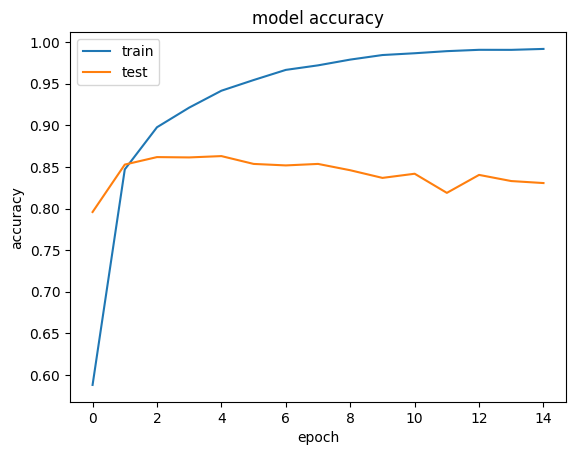

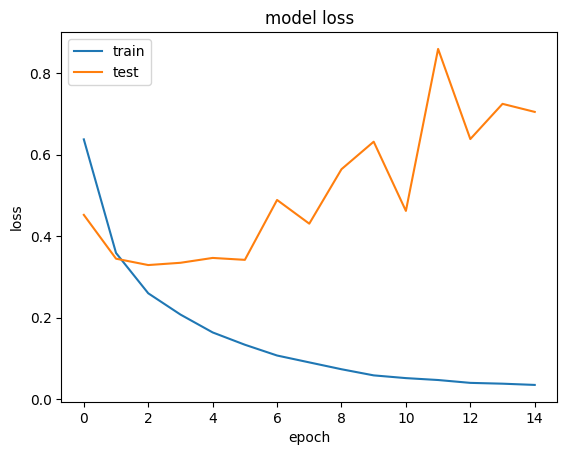

In [81]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Making Predictions on Live IMDb data

In [82]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,everything evrywhere at once,Evelyn Wang and her husband Waymond run a laun...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,avatar,Soothing for eye! Not for mind!\nAfter watchin...,3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [83]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [84]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = tf.keras.preprocessing.sequence.pad_sequences(unseen_tokenized, maxlen=150, padding='post', truncating='post')

In [85]:
# Passing tokenised instance to the LSTM model for predictions
prediction_lstm = lstm_model.predict(unseen_padded)

prediction_lstm

1/1 [==============================] - 0s 451ms/step


array([[8.2876824e-04],
       [9.9811900e-01],
       [1.9114382e-03],
       [1.1592988e-03],
       [9.9917358e-01],
       [1.0921131e-03]], dtype=float32)

In [97]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(prediction_lstm*10, 5)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,everything evrywhere at once,Evelyn Wang and her husband Waymond run a laun...,9,0.00829
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.98119
2,avatar,Soothing for eye! Not for mind!\nAfter watchin...,3,0.01911
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.01159
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.99174
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.01092


# Making prediction on user input review

In [87]:
def predict(sentence):
    user_text = []
    user_text.append(sentence)
    seq = tokenizer.texts_to_sequences(user_text)
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=150, padding='post', truncating='post')
    probability = (lstm_model.predict(pad))[0][0]
    if probability > 0.5:
        print(f'Positive | {np.round(probability*100, 2)}%')
    else:
        print(f'Negative | {100 - (np.round(probability*100, 2))}%')

In [88]:
predict(str(input('Enter a movie review: ')))

Enter a movie review: The first (and the most crucial) movie in the Harry Potter Franchise is certainly one it's best- it happened to be my first exposure to the world of Harry Potter and the lifelong obsession that was about to follow.   The first shot of Hogwarts- immediately mesmerizing with it's tall towers and windows glimmering with candle-light as the bewitching soundtrack by John Williams plays- is a testament to how well the film is made. Minor details like the gorgeous mountains and lakes that surround Hogwarts lurk in the background or at the edges of the frames and make the whole thing dreamier, and magical. It's all so enchanting that one doesn't nitpick the special effects (which while being perfectly good for that time, seem a bit funny today). The credit for this certainly goes to JK Rowling more than any one person because it's such a well realised world- it's the details of her imagination, after all, that the movie brings on the screen. The story is- as we know- one 

# Confusion Matrix on Test Dataset

In [89]:
y_pred = np.where(lstm_model.predict(X_test)>0.5, 1, 0)

157/157 [==============================] - 12s 76ms/step


In [90]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      2648
           1       0.80      0.85      0.83      2352

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [91]:
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index = [['actual', 'actual'], ['positive', 'negative']],
    columns = [['predicted', 'predicted'], ['positive', 'negative']]
    )

predicted         
                 positive negative
actual positive      2151      348
       negative       497     2004